In [ ]:
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 5.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import nltk
from pytorch_metric_learning import losses, miners, distances

ModuleNotFoundError: ignored

In [ ]:
device = torch.device('cuda')
data_postEmb = np.concatenate([np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(1).npy',allow_pickle=True),
                    np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(2).npy',allow_pickle=True),
                    np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(3).npy',allow_pickle=True),
                    np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(4).npy',allow_pickle=True),
                    np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(5).npy',allow_pickle=True)[:67809],])
text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/blogtext_2sent.csv')[:467809]

#data_postEmb = np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_train_top500.npy',allow_pickle=True)
#text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/blogtext_train_top500(1).csv')

data_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in data_postEmb]
ids = torch.tensor(list(text['id']))

In [ ]:
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim = 384, n_hidden = 384 , embed_dim = 64, token_emb=192):
        super(BiLSTM_Attention, self).__init__()
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.embed_dim = embed_dim
        #self.token_emb = token_emb
        self.reduction = nn.Linear(n_hidden*2, n_hidden)

        self.gru1 = nn.GRU(input_dim, n_hidden, bidirectional=True, dropout = 0.13)
        self.gru2 = nn.GRU(n_hidden, n_hidden, bidirectional=True, dropout = 0.1)
        self.fc_layer = nn.Sequential(
            nn.Linear(n_hidden * 2, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, 512),
            nn.ELU(inplace=True),
            nn.Linear(512, 384),  
            nn.Dropout(0.13),
            nn.ELU(inplace=True),
            nn.Linear(384, embed_dim),
        )

    def attention_net(self, gru_output, final_state):
        hidden = final_state.view(-1, self.n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(gru_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(gru_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data#.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        inp = X.permute(1, 0, 2) # inp : [len_seq, batch_size, embedding_dim]
        hidden_state = Variable(torch.zeros(1*2, len(X), self.n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, _ = self.gru1(inp)
        
        # Bi-directrional sum
        output = self.reduction(output) + inp    # bi-direction concat 후 dense layer로 차원 축소

        output, final_hidden_state = self.gru2(output)#.unsqueeze(0))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.fc_layer(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]


In [ ]:
net=BiLSTM_Attention(embed_dim=64)
#net.load_state_dict(torch.load('/content/drive/MyDrive/BlogAuthorClass/Trained_models/~').state_dict())

net.cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


BiLSTM_Attention(
  (reduction): Linear(in_features=768, out_features=384, bias=True)
  (gru1): GRU(384, 384, dropout=0.13, bidirectional=True)
  (gru2): GRU(384, 384, dropout=0.1, bidirectional=True)
  (fc_layer): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=512, out_features=384, bias=True)
    (5): Dropout(p=0.13, inplace=False)
    (6): ELU(alpha=1.0, inplace=True)
    (7): Linear(in_features=384, out_features=64, bias=True)
  )
)

In [ ]:
# sequential dataloader 만들기
# https://towardsdatascience.com/dataloader-for-sequential-data-using-pytorch-deep-learning-framework-part-2-ed3ad5f6ad82

'''
	Args:
		data: list of tuple (training sequence, label)
	Return:
		padded_seq - Padded Sequence, tensor of shape (batch_size, padded_length)
		length - Original length of each sequence(without padding), tensor of shape(batch_size)
		label - tensor of shape (batch_size)
'''

emb_size=384
def collate_fn(data):
    #sorting is important for usage pack padded sequence (used in model). It should be in decreasing order.
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, label = zip(*data)
    length = [len(seq) for seq in sequences]
    padded_seq = torch.zeros(len(sequences), max(length), emb_size)#.long()
    for i, seq in enumerate(sequences):
        end = length[i]
        padded_seq[i,:end] = seq
    return padded_seq, torch.from_numpy(np.array(length)).to(device), torch.from_numpy(np.array(label)).to(device)

In [ ]:
subset_files = ['/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(1).npy',
                '/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(2).npy',
                '/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(3).npy',
                '/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(4).npy',
                #'/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(5).npy',
                #'/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(6).npy',
                ]

text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/blogtext_2sent.csv')#[100000:300000]
device = torch.device('cuda')

def sample_subset(files, nums=2) :
    samples = np.sort(np.random.choice(range(len(files)),size=nums, replace=False))
    outemb = [np.load(files[s], allow_pickle=True) for s in samples]
    begin, end = samples*100000, samples*100000 + 100000
    outtxt = [text[b:e] for b,e in zip(begin, end)]
    return list(np.concatenate(outemb)), pd.concat(outtxt)
#data_postEmb, subtxt = sample_subset(subset_files)
#data_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in data_postEmb]
#ids = torch.tensor(list(subtxt['id']))

In [ ]:
# fixed train
data_postEmb = np.load('/content/drive/MyDrive/BlogAuthorClass/SampledID/postEmb_384dim_10samples(train).npy',allow_pickle=True)
text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/SampledID/blogtext_train_sample(10ids).csv')

data_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in data_postEmb]
ids = torch.tensor(list(text['id']))

In [ ]:
# validation set

device = torch.device('cuda')
test_postEmb = np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_test_top500.npy',allow_pickle=True)
test_text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/blogtext_test_top500(1).csv')

test_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in test_postEmb]
test_ids = torch.tensor(list(test_text['id']))

testloader = DataLoader(list(zip(test_postEmb, test_ids)),
                        batch_size=300,
                        #batch_size=64,
                        shuffle=True,
                        collate_fn=collate_fn)

In [ ]:
#train
dataloader = DataLoader(list(zip(data_postEmb, ids)),
                        #batch_size=100,
                        batch_size=64,
                        shuffle=True,
                        collate_fn=collate_fn)
#validation
testloader = DataLoader(list(zip(test_postEmb, test_ids)),
                        batch_size=300,
                        #batch_size=64,
                        shuffle=True,
                        collate_fn=collate_fn)

In [ ]:
train_loss_list = []
test_loss_list = []
#train_loss_list = np.load('/content/drive/MyDrive/BlogAuthorClass/KPS/v13_tr_loss(Lifted0p05Pos01_lr0p002_400epo(120best)).npy').tolist()

In [ ]:
#miner = miners.MultiSimilarityMiner()
miner = miners.TripletMarginMiner(margin=0.2,
                                  #margin=0.15,
                          type_of_triplets="semihard",)
                          #type_of_triplets="hard")  # all hard semihard easy
#loss_func = losses.TripletMarginLoss(#margin=0.05,
#                                     margin=0.5,
#                                     swap=True,
#                                     #smooth_loss=True,
#                                     triplets_per_anchor=64)
loss_func = losses.LiftedStructureLoss(neg_margin=0.05, # baseline
                                       pos_margin=0.01, # baseline
                                       distance=distances.LpDistance(p=2.))#,normalize_embeddings=False))


optimizer = optim.Adam(net.parameters(), lr = 0.0002)   #0.00000005
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda step: 0.995 ** step,
                                        last_epoch=-1,
                                        verbose=False)

#train_loss_list=[]
#val_accuracy=[]

In [ ]:
suc=0
fal=0

print("Adam")
for epoch in range(30):
    
    ###  RAM 용적이 제한된 경우, 학습 데이터를 shuffle해가며 학습  ###
    #data_postEmb, subtxt = sample_subset(subset_files)
    #data_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in data_postEmb]
    #ids = torch.tensor(list(subtxt['id']))
    #dataloader = DataLoader(list(zip(data_postEmb, list(subtxt['id']))),
    #                        batch_size=384,
    #                        shuffle=True,
    #                        collate_fn=collate_fn)
    train_loss = 0
    for data, _, labels in dataloader :
        net.train()   # dropout on
        try :
            optimizer.zero_grad()
            embeddings = net(data.cuda())
            hard_pairs = miner(embeddings[0], labels)
            loss = loss_func(embeddings[0], labels, hard_pairs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
            suc+=1
        except Exception as e :
            print(e)
            fal+=1
    
        #test_loss = 0
        #for data_te, __, labels_te in testloader :
        #    net.eval()    # dropout off
        #    embeddings = net(data_te.cuda())
        #    hard_pairs = miner(embeddings[0], labels_te)
        #    test_loss += loss_func(embeddings[0], labels_te, hard_pairs).item()
    
    scheduler.step()
    test_loss_list.append(test_loss / len(testloader))
    train_loss_list.append(train_loss / len(dataloader))
    #del 

    #if epoch % 2 == 0:
    #    print("Epoch :", epoch, "Loss : ", loss)
    #    print(suc/(suc+fal), suc)
    print("Epoch :", epoch, "Train_Loss : ", train_loss / len(dataloader),)# "Test_Loss : ", test_loss)
    print(suc/(suc+fal), suc)


Adam
Epoch : 0 Train_Loss :  3.614785118342036
1.0 808
Epoch : 1 Train_Loss :  3.607934481436663
1.0 1616
Epoch : 2 Train_Loss :  3.5908882188619953
1.0 2424
Epoch : 3 Train_Loss :  3.6300947649939226
1.0 3232
Epoch : 4 Train_Loss :  3.578184699067975
1.0 4040
Epoch : 5 Train_Loss :  3.5888605080176106
1.0 4848
Epoch : 6 Train_Loss :  3.6622183972065994
1.0 5656
Epoch : 7 Train_Loss :  3.663795183643256
1.0 6464
Epoch : 8 Train_Loss :  3.6189186385657526
1.0 7272
Epoch : 9 Train_Loss :  3.6581105918872474
1.0 8080
Epoch : 10 Train_Loss :  3.5981202280462377
1.0 8888
Epoch : 11 Train_Loss :  3.6091211182941305
1.0 9696
Epoch : 12 Train_Loss :  3.616771696965293
1.0 10504
Epoch : 13 Train_Loss :  3.594706532683703
1.0 11312
Epoch : 14 Train_Loss :  3.6202710606526622
1.0 12120
Epoch : 15 Train_Loss :  3.6735290830383205
1.0 12928
Epoch : 16 Train_Loss :  3.5996536963646957
1.0 13736
Epoch : 17 Train_Loss :  3.592785271345684
1.0 14544
Epoch : 18 Train_Loss :  3.665264377499571
1.0 15352


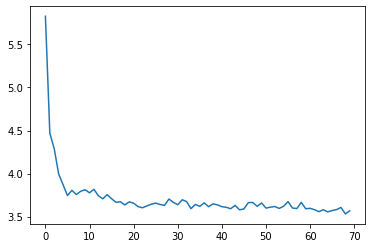

In [ ]:
plt.plot(train_loss_list[85:])
#plt.plot(test_loss_list)

In [ ]:
#torch.save(net,"/content/drive/MyDrive/BlogAuthorClass/KPS/GRUmodel_v13(Lifted0p05Pos01_file1_top500_margin0p05_KPS)(lr0p001_500epo_end)")
torch.save(net,"/content/drive/MyDrive/BlogAuthorClass/KPS/GRUmodel_v13(Lifted0p05Pos01_file1_top500_margin0p05_KPS)(잡탕)")

In [ ]:
#dataloader
dataloader = DataLoader(list(zip(data_postEmb, ids)),
                        #batch_size=384,
                        batch_size=100,
                        shuffle=True,
                        collate_fn=collate_fn)

NameError: ignored

In [ ]:
#train_loss_list=[]
#val_accuracy=[]

In [ ]:
#v12 -> v13 : linear layer 추가
torch.save(net,"/content/drive/MyDrive/BlogAuthorClass/Trained_models/GRUmodel_v13(Lifted0p05Pos01_Large384L2)")
#torch.save(net,"/content/drive/MyDrive/BlogAuthorClass/Trained_models/GRUmodel_v13(Lifted0p005Pos001_Large384L2)")
np.save('/content/drive/MyDrive/BlogAuthorClass/Trained_models/v13_tr_loss(Lifted0p05Pos01_Large384L2)',train_loss)

In [ ]:
net.cuda()
#for data, labels in dataloader :
#print(padded_seq.shape)
#print(seq,seq.shape)
#print(padded_seq[i,:end].shape)
#padded_seq[i,:end] = seq
#print(padded_seq)
#with torch.no_grad() :
for data,_,labels in dataloader :
    net.train()   # dropout on
    optimizer.zero_grad()
    embeddings = net(data.to(device))
    hard_pairs = miner(embeddings[0], labels)
    loss = loss_func(embeddings[0], labels, hard_pairs)
    loss.backward()
    optimizer.step()
    break

In [ ]:
id_series = text['id'].unique()
ind_list=[]
for i in id_series :
    ind = text[text["id"]==i].index.to_list()
    ind_list.append(ind)
np.random.shuffle(ind_list)
shuffled_ind = sum(ind_list, [])

## id sampled

In [ ]:
# fixed train

###
print("25ids")
net.load_state_dict(torch.load('/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/GRUmodel_v13(25ids)(2)').state_dict())

data_postEmb = np.load('/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/postEmb_384dim_25samples(train).npy',allow_pickle=True)
text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/blogtext_train_sample(25ids).csv')

data_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in data_postEmb]
ids = torch.tensor(list(text['id']))

dataloader = DataLoader(list(zip(data_postEmb, ids)),
                        #batch_size=100,
                        batch_size=64,
                        shuffle=True,
                        collate_fn=collate_fn)

miner = miners.TripletMarginMiner(margin=0.15,
                          type_of_triplets="all")  # all hard semihard easy
loss_func = losses.LiftedStructureLoss(neg_margin=0.05, # baseline
                                       pos_margin=0.01, # baseline

                                       distance=distances.LpDistance(p=2.))#,normalize_embeddings=False))

optimizer = optim.Adam(net.parameters(), lr = 0.001)   #0.00000005
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda step: 0.98 ** step,
                                        last_epoch=-1,
                                        verbose=False)

suc=0
fal=0


for epoch in range(30):
    train_loss = 0
    for data, _, labels in dataloader:
        net.train()   # dropout on
        try :
            optimizer.zero_grad()
            embeddings = net(data.cuda())
            hard_pairs = miner(embeddings[0], labels)
            loss = loss_func(embeddings[0], labels, hard_pairs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
            suc+=1
        except Exception as e :
            print(e)
            fal+=1
    scheduler.step()
    #train_loss_list.append(train_loss / len(dataloader))
    print("Epoch :", epoch, "Loss : ", train_loss)
    print(suc/(suc+fal), suc)
    suc=0
    fal=0

miner = miners.TripletMarginMiner(margin=0.15,
                          type_of_triplets="all")
for epoch in range(10):
    train_loss = 0
    for data, _, labels in dataloader:
        net.train()   # dropout on
        try :
            optimizer.zero_grad()
            embeddings = net(data.cuda())
            hard_pairs = miner(embeddings[0], labels)
            loss = loss_func(embeddings[0], labels, hard_pairs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
            suc+=1
        except Exception as e :
            print(e)
            fal+=1
    scheduler.step()
    #train_loss_list.append(train_loss / len(dataloader))
    print("Epoch :", epoch, "Loss : ", train_loss)
    print(suc/(suc+fal), suc)
    suc=0
    fal=0

torch.save(net,"/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/GRUmodel_v13(25ids)(2)")
del data_postEmb, text


###
print("100ids")
net.load_state_dict(torch.load('/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/GRUmodel_v13(25ids)(2)').state_dict())

data_postEmb = np.load('/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/postEmb_384dim_25samples(train).npy',allow_pickle=True)
text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/blogtext_train_sample(25ids).csv')

data_postEmb = [torch.tensor(sent_seq, device=device) for sent_seq in data_postEmb]
ids = torch.tensor(list(text['id']))

dataloader = DataLoader(list(zip(data_postEmb, ids)),
                        #batch_size=100,
                        batch_size=64,
                        shuffle=True,
                        collate_fn=collate_fn)

miner = miners.TripletMarginMiner(margin=0.15,
                          type_of_triplets="all")  # all hard semihard easy
#loss_func = losses.LiftedStructureLoss(neg_margin=0.05, # baseline
#                                       pos_margin=0.01, # baseline
#                                       distance=distances.LpDistance(p=2.))#,normalize_embeddings=False))

#optimizer = optim.Adam(net.parameters(), lr = 0.001)   #0.001
#scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                        lr_lambda=lambda step: 0.98 ** step,
#                                        last_epoch=-1,
#                                        verbose=False)

suc=0
fal=0


for epoch in range(30):
    train_loss = 0
    for data, _, labels in dataloader:
        net.train()   # dropout on
        try :
            optimizer.zero_grad()
            embeddings = net(data.cuda())
            hard_pairs = miner(embeddings[0], labels)
            loss = loss_func(embeddings[0], labels, hard_pairs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
            suc+=1
        except Exception as e :
            print(e)
            fal+=1
    scheduler.step()
    #train_loss_list.append(train_loss / len(dataloader))
    print("Epoch :", epoch, "Loss : ", train_loss)
    print(suc/(suc+fal), suc)
    suc=0
    fal=0

miner = miners.TripletMarginMiner(margin=0.15,
                          type_of_triplets="all")
for epoch in range(10):
    train_loss = 0
    for data, _, labels in dataloader:
        net.train()   # dropout on
        try :
            optimizer.zero_grad()
            embeddings = net(data.cuda())
            hard_pairs = miner(embeddings[0], labels)
            loss = loss_func(embeddings[0], labels, hard_pairs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            gc.collect()
            torch.cuda.empty_cache()
            suc+=1
        except Exception as e :
            print(e)
            fal+=1
    #scheduler.step()
    #train_loss_list.append(train_loss / len(dataloader))
    print("Epoch :", epoch, "Loss : ", train_loss)
    print(suc/(suc+fal), suc)
    suc=0
    fal=0

torch.save(net,"/content/drive/MyDrive/BlogAuthorClass/SampledID(2)/GRUmodel_v13(25ids)(2)")
del data_postEmb, text 

25ids
Epoch : 0 Loss :  1851.730654001236
1.0 422
Epoch : 1 Loss :  1667.5867809057236
1.0 422
Epoch : 2 Loss :  1453.113211631775
1.0 422
Epoch : 3 Loss :  1398.6718192100525
1.0 422
Epoch : 4 Loss :  1418.0404500961304
1.0 422
Epoch : 5 Loss :  1540.956978559494
1.0 422
Epoch : 6 Loss :  1338.38130235672
1.0 422
Epoch : 7 Loss :  1371.8539288043976
1.0 422
Epoch : 8 Loss :  1328.3064476847649
1.0 422
Epoch : 9 Loss :  1298.9918791651726
1.0 422
Epoch : 10 Loss :  1268.7404308319092
1.0 422
Epoch : 11 Loss :  1458.278264760971
1.0 422
Epoch : 12 Loss :  1243.9856273531914
1.0 422
Epoch : 13 Loss :  1210.214589893818
1.0 422
Epoch : 14 Loss :  1218.032209098339
1.0 422
Epoch : 15 Loss :  1176.7303488254547
1.0 422
Epoch : 16 Loss :  1149.1760668158531
1.0 422
Epoch : 17 Loss :  1203.8077200651169
1.0 422
Epoch : 18 Loss :  1128.0074341893196
1.0 422
Epoch : 19 Loss :  1178.3327382802963
1.0 422
Epoch : 20 Loss :  1670.8216650485992
1.0 422
Epoch : 21 Loss :  1367.0105098485947
1.0 422
